In [61]:
import rasterio
from rasterio.merge import merge
from rasterio.mask import mask
import geopandas as gp
import numpy as np
import json
import os
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd

In [47]:
#paths
current = os.getcwd()
inp = os.path.dirname(current) + "/Data Outputs/"
tile_folder = os.path.dirname(os.path.dirname(current)) + "/Deforestation Raw Data/Loss Year/"
tile_tree_folder = os.path.dirname(os.path.dirname(current)) + "/Deforestation Raw Data/Tree Cover/"

In [105]:
gdf_CF = gp.read_file(inp + "Community_Forests_Zambia_V1.shp")

In [49]:


# List of Hansen tile file paths
tile_paths = [
    tile_folder + "Hansen_GFC-2023-v1.11_lossyear_00N_020E.tif",
    tile_folder + "Hansen_GFC-2023-v1.11_lossyear_00N_030E.tif",
    tile_folder + "Hansen_GFC-2023-v1.11_lossyear_10S_020E.tif",
    tile_folder + "Hansen_GFC-2023-v1.11_lossyear_10S_030E.tif"
]

tile_paths_tree_cover  = [
    tile_tree_folder + "Hansen_GFC-2023-v1.11_treecover2000_00N_020E.tif",
    tile_tree_folder + "Hansen_GFC-2023-v1.11_treecover2000_00N_030E.tif",
    tile_tree_folder + "Hansen_GFC-2023-v1.11_treecover2000_10S_020E.tif",
    tile_tree_folder + "Hansen_GFC-2023-v1.11_treecover2000_10S_030E.tif"
]


# Open all tiles as rasterio objects
src_files_to_mosaic = [rasterio.open(fp) for fp in tile_paths]
# Merge the tiles into one mosaic
mosaic, out_trans = merge(src_files_to_mosaic)

# Open all tiles as rasterio objects
src_files_to_mosaic_tree = [rasterio.open(fp) for fp in tile_paths_tree_cover]
# Merge the tiles into one mosaic
mosaic_t, out_trans_t = merge(src_files_to_mosaic_tree)

In [50]:
#copy metadata from the first tile and update it for the mosaic
mosaic_meta = src_files_to_mosaic[0].meta.copy()
mosaic_meta.update({
    "height": mosaic.shape[1],
    "width": mosaic.shape[2],
    "transform": out_trans
})

#save the merged mosaic
merged_raster_path = inp + "merged_lossyear.tif"
with rasterio.open(merged_raster_path, "w", **mosaic_meta) as dest:
    dest.write(mosaic)

for src in src_files_to_mosaic:
    src.close()


#copy metadata from the first tile and update it for the mosaic
mosaic_meta_tree = src_files_to_mosaic_tree[0].meta.copy()
mosaic_meta_tree.update({
    "height": mosaic_t.shape[1],
    "width": mosaic_t.shape[2],
    "transform": out_trans_t
})

#save the merged mosaic
merged_raster_path_tree = inp + "merged_tree_cover.tif"
with rasterio.open(merged_raster_path_tree, "w", **mosaic_meta_tree) as dest:
    dest.write(mosaic_t)

for src in src_files_to_mosaic_tree:
    src.close()

In [106]:
previous_crs = gdf_CF.crs
gdf = gdf_CF.to_crs(src.crs)

In [107]:
# Prepare a list to store the long-format rows
rows = []

# Each pixel is approximately 30 m x 30 m (~900 m²)
pixel_area = 30 * 30

# Open both the merged lossyear and treecover rasters for analysis
with rasterio.open(merged_raster_path) as src_loss, rasterio.open(merged_raster_path_tree) as src_tree:
    for idx, row in gdf.iterrows():
        geom = [row["geometry"]]
        try:
            # Mask both rasters using the polygon geometry
            out_loss, out_transform = mask(src_loss, geom, crop=True)
            out_tree, out_transform_tree = mask(src_tree, geom, crop=True)
        except Exception as e:
            print(f"Error masking polygon {idx}: {e}")
            new_row = row.copy()
            new_row["total_def"] = None
            new_row["year"] = None
            new_row["year_def_ha"] = 0
            rows.append(new_row)
            continue

        # Get the data arrays
        loss_data = out_loss[0]   # lossyear data: 0 if no loss, else 1-20 (indicating the year)
        tree_data = out_tree[0]   # treecover data: percentage (0-100) of forest cover in 2000

        # Create a mask for pixels where forest loss occurred (loss_data > 0)
        loss_mask = loss_data > 0

        # For each pixel that lost forest, calculate the weighted forested area lost:
        # weighted_loss = pixel_area * (treecover percentage / 100)
        weighted_loss = np.where(loss_mask, pixel_area * (tree_data / 100.0), 0)
        total_weighted_area_m2 = np.sum(weighted_loss)
        total_weighted_area_ha = total_weighted_area_m2 / 10000.0  # convert m² to hectares

        # Breakdown the weighted loss by year:
        year_dict = {}
        unique_vals, count = np.unique(loss_data[loss_mask], return_counts=True)
        for val in unique_vals:
            if val > 0:
                # Create a mask for pixels corresponding to this specific loss year
                year_mask = (loss_data == val)
                # Calculate weighted loss only for these pixels
                weighted_loss_year = pixel_area * (tree_data[year_mask] / 100.0)
                area_year_m2 = np.sum(weighted_loss_year)
                area_year_ha = area_year_m2 / 10000.0
                loss_year = 2000 + int(val)  # Mapping: 1 -> 2001, 2 -> 2002, etc.
                year_dict[loss_year] = area_year_ha

        # Create a long-format record: one row per year of deforestation
        if year_dict:
            for y, area in year_dict.items():
                new_row = row.copy()
                new_row["total_def"] = total_weighted_area_ha
                new_row["year"] = y
                new_row["year_def_ha"] = area
                rows.append(new_row)
        else:
            # If no deforestation detected, add one row with zero values
            new_row = row.copy()
            new_row["total_def"] = 0
            new_row["year"] = None
            new_row["year_def_ha"] = 0
            rows.append(new_row)

# Create a long-format GeoDataFrame from the rows
long_gdf = gp.GeoDataFrame(rows, crs=gdf.crs)

In [116]:
long_gdf['tot_perc_def'] = long_gdf['total_def']/long_gdf['area_ha']
long_gdf['year_perc_def'] = long_gdf['year_def_ha']/long_gdf['area_ha']

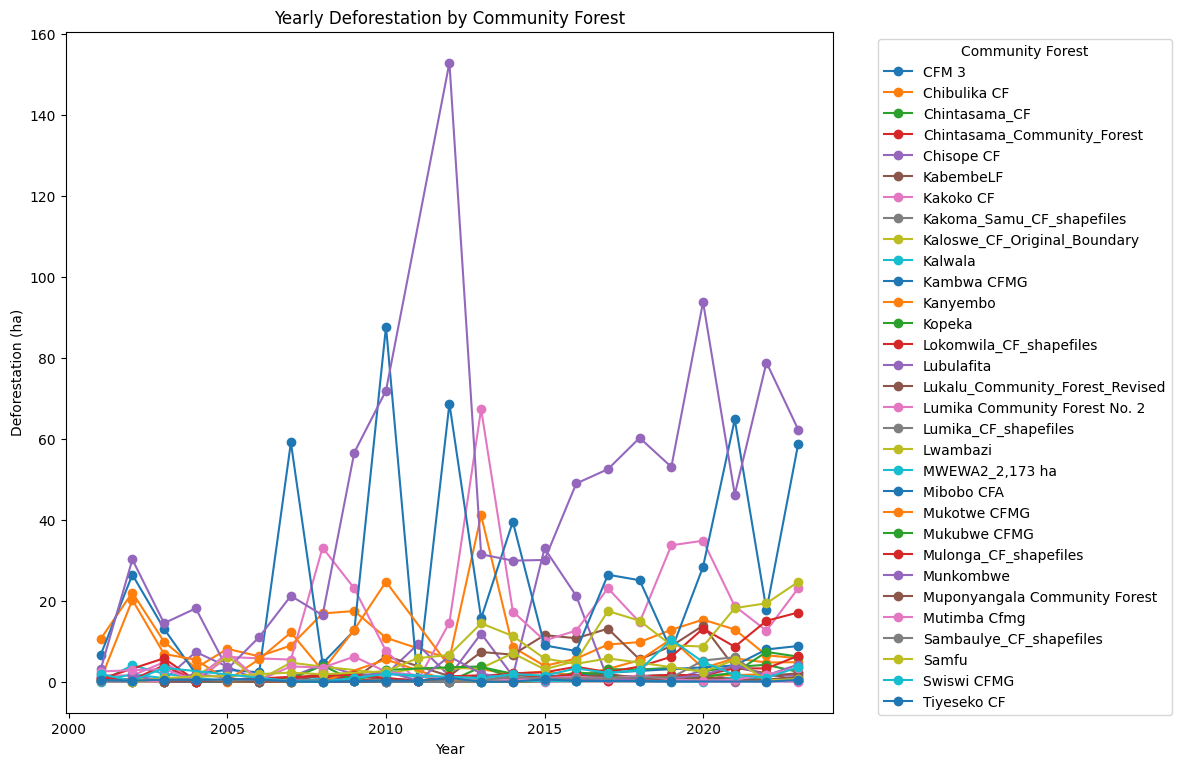

In [112]:
#plot 

# Adjust 'CF_Name' to your actual column name; otherwise, you might use an index.
id_col = "CF_desc" if "CF_desc" in long_gdf.columns else "id"

# If there's no identifier column, create one from the index.
if id_col not in gdf.columns:
    long_gdf = long_gdf.reset_index().rename(columns={"index": "id"})
    id_col = "id"

# Create a plot: x axis as 'year' and y axis as 'yearly_deforestation_ha'
plt.figure(figsize=(12, 8))
for key, grp in long_gdf.groupby(id_col):
    plt.plot(grp["year"], grp["year_def_ha"],
             marker="o", linestyle="-", label=key)
plt.xlabel("Year")
plt.ylabel("Deforestation (ha)")
plt.title("Yearly Deforestation by Community Forest")

plt.legend(title="Community Forest",
           bbox_to_anchor=(1.05, 1),  # Shift legend to the right
           loc="upper left")         # Position the legend's upper left corner
plt.tight_layout()  # Ensure there's room for the legend
plt.show()
plt.show()

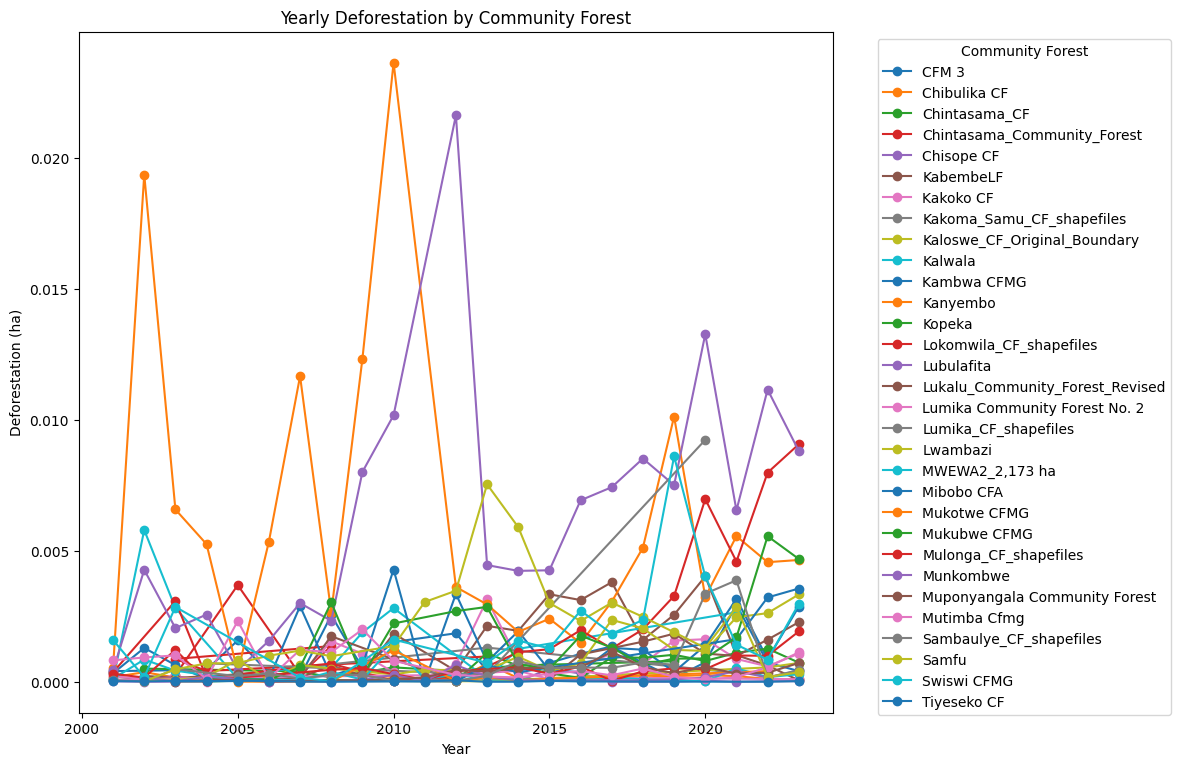

In [117]:
#plot 

# Adjust 'CF_Name' to your actual column name; otherwise, you might use an index.
id_col = "CF_desc" if "CF_desc" in long_gdf.columns else "id"

# If there's no identifier column, create one from the index.
if id_col not in gdf.columns:
    long_gdf = long_gdf.reset_index().rename(columns={"index": "id"})
    id_col = "id"

# Create a plot: x axis as 'year' and y axis as 'yearly_deforestation_ha'
plt.figure(figsize=(12, 8))
for key, grp in long_gdf.groupby(id_col):
    plt.plot(grp["year"], grp["year_perc_def"],
             marker="o", linestyle="-", label=key)
plt.xlabel("Year")
plt.ylabel("Deforestation (ha)")
plt.title("Yearly Deforestation by Community Forest")

plt.legend(title="Community Forest",
           bbox_to_anchor=(1.05, 1),  # Shift legend to the right
           loc="upper left")         # Position the legend's upper left corner
plt.tight_layout()  # Ensure there's room for the legend
plt.show()
plt.show()

In [120]:
#interactive plot
import plotly.io as pio

pio.renderers.default = 'browser' 

#clean

df = pd.DataFrame(long_gdf.drop(columns="geometry"))


In [124]:

# Identify a column with community forest names/IDs
id_col = "CF_desc" if "CF_desc" in df.columns else "id"
if id_col not in df.columns:
    df = df.reset_index().rename(columns={"CF_desc": "id"})
    id_col = "id"

df['year_perc_def1'] = df['year_perc_def']*100

# Create a line plot with Plotly Express
fig = px.line(
    df, 
    x="year", 
    y="year_perc_def1", 
    color=id_col, 
    title="Yearly Deforestation by Community Forest as Percentage of the Total Area",
    labels={"year": "Year", "year_perc_def1": "Deforestation (%)"}
)

# Move the legend to the right
fig.update_layout(
    legend=dict(
        x=1.05,  # position legend to the right
        y=1,
        orientation='v'
    )
)
fig.show()

In [125]:
# Identify a column with community forest names/IDs
id_col = "CF_desc" if "CF_desc" in df.columns else "id"
if id_col not in df.columns:
    df = df.reset_index().rename(columns={"CF_desc": "id"})
    id_col = "id"

# Create a line plot with Plotly Express
fig = px.line(
    df, 
    x="year", 
    y="year_def_ha", 
    color=id_col, 
    title="Yearly Deforestation by Community Forest",
    labels={"year": "Year", "year_def_ha": "Deforestation (ha)"}
)

# Move the legend to the right
fig.update_layout(
    legend=dict(
        x=1.05,  # position legend to the right
        y=1,
        orientation='v'
    )
)
fig.show()

In [126]:
excel_file = pd.DataFrame(long_gdf.drop(columns=['geometry']))

In [127]:
excel_file.to_excel(inp + 'Deforestation.xlsx', index=False)

In [101]:
# Save the updated shapefile with deforestation statistics
output_shapefile = "Community_Forests_Zambia_Deforestation.shp"
long_gdf.to_file(inp + output_shapefile)

print("Merged tiles processed and deforestation analysis completed. Results saved to:", output_shapefile)

Merged tiles processed and deforestation analysis completed. Results saved to: Community_Forests_Zambia_Deforestation.shp


/var/folders/fv/jg2h591964n6jt_g1g7zytz40000gn/T/ipykernel_3763/545002542.py:3: UserWarning:

Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.

/Users/vanessafigueroa/Documents/Personal projects/Deforestation/DeforestationProject/.venv/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning:

Normalized/laundered field name: 'year_def_ha' to 'year_def_h'



In [ ]:
# Ver estos datos

#https://cds.climate.copernicus.eu/datasets/satellite-land-cover?tab=overview
#https://glad.umd.edu/ard/home

#verification of geometries